# **Import Required Libraries**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import mutual_info_regression


# **Load and Preprocess Data**
We drop the 'Town' and 'Address' columns, then encode the booleans as integers 1 and 0, before splitting the dataset into train-test and scaling appropriately as KNN is a distance-based model

In [7]:
df = pd.read_csv('../datasets/Final_ResaleData.csv')
print('Dataset shape:', df.shape)
df.head()


X = df[['Year', 'Month', 'Flat_Type', 'Storey', 'Floor_Area',
'Remaining_Lease', 'Distance_MRT', 'Distance_Mall',
'Within_1km_of_Pri', 'Mature']].copy()
y = df['Price']

# Encode booleans as integers
X['Within_1km_of_Pri'] = X['Within_1km_of_Pri'].astype(int)
X['Mature'] = X['Mature'].astype(int)

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Dataset shape: (212868, 13)


# **Feature Selection**
This section is to investigate if there are any irrelevant features that can be removed. This is because kNN is distance based and can fall prey to curse of dimensionality, where more features make distances less meaningful. Generally, using the lecture method of n < m/5, our dataset should be safe (n=13, m=212868), but it is a good practice to investigate. The methods used here will be:
- Correlation
- Information Gain

Correlation
- It was seen that 'Flat_Type' and 'Floor_Area' were highly correlated with a score of 0.95, hence I removed 'Floor_Area' as a feature.

Information Gain
- Using the mean of all calculated mutual information scores as the threshold, I found that only 'Flat_Type', 'Floor_Area', and 'Remaining_Lease' had the strongest scores, and we had removed 'Floor_Area" as a feature due to correlation. As such, this method was not as informative, and all the features less 'Floor_Area' will be kept. 

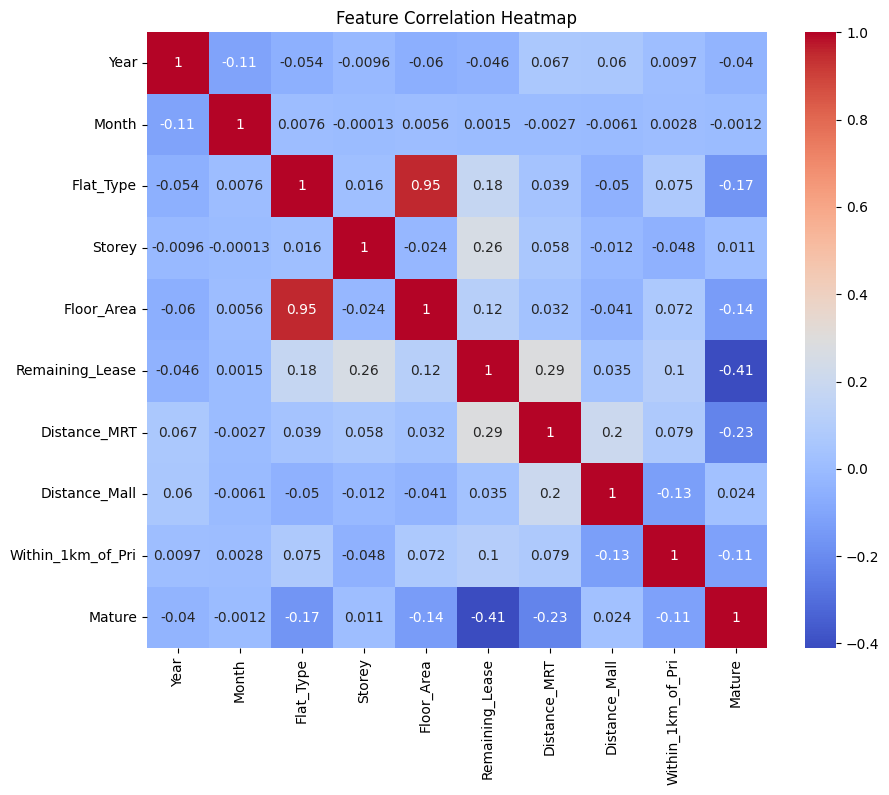

Mutual Information Scores:
Floor_Area           0.381120
Flat_Type            0.292272
Remaining_Lease      0.141420
Year                 0.105237
Distance_MRT         0.093520
Distance_Mall        0.087197
Storey               0.051716
Mature               0.035456
Within_1km_of_Pri    0.005197
Month                0.001601
dtype: float64

Selected Features based on Mutual Information (threshold=0.11947356744712608):
['Flat_Type', 'Floor_Area', 'Remaining_Lease']


In [13]:
# **Correlation**
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# **Mutual Information Regression**
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns)
print("Mutual Information Scores:")
print(mi_series.sort_values(ascending=False))
mi_threshold = mi_series.mean()
selected_features = mi_series[mi_series > mi_threshold].index.tolist()
print("\nSelected Features based on Mutual Information (threshold={}):".format(mi_threshold))
print(selected_features)

#Removal of Floor_Area due to high correlation with Flat_Type
X_train = X_train.drop(columns=['Floor_Area'])
X_val = X_val.drop(columns=['Floor_Area'])


# **Train kNN Model**
A pipeline is built for preprocessing and a KNN regressor. Hyperparameter fine-tuning is then carried out using HalvingGridSearchCV instead of normal GridSearchCV as the dataset is large (~213k samples). HalvingGridSearchCV provides a more efficient approach by iteratively evaluating models on increasing subsets of the data, retaining only the best-performing hyperparameter combinations in each round. This allows us to identify optimal parameters much faster while maintaining comparable accuracy.

After finetuning, here are the best hyperparameters:
- 'n_neighbours': 9
- 'weights': distance
- 'norm': 1


In [ ]:
# Pipeline kNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())])


# Hyperparameter Tuning for kNN
knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31, 41, 51],
    'knn__p': [1, 2],
    'knn__weights': ['uniform', 'distance']
}


# GridSearchCV for kNN
knn_model = HalvingGridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_params,
    factor=2,  # each iteration keeps top 1/2 of candidates
    resource='n_samples',  # uses subset of samples as the “resource”
    max_resources='auto',  # use up to full dataset at final round
    cv=5,  
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

knn_model.fit(X_train, y_train)

print("Best Parameters:", knn_model.best_params_)


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 5321
max_resources_: 170294
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 40
n_resources: 5321
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 20
n_resources: 10642
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 10
n_resources: 21284
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 3
n_candidates: 5
n_resources: 42568
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 3
n_resources: 85136
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 170272
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}


# **Evaluate kNN Model**
Evaluation is carried out using RMSE, MAE and R^2 to assess prediction accuracy. The scores are as such:
- RMSE: 48945.76
- MAE: 34143.04
- R^2: 0.914

On average, the model’s resale price predictions are off by about $34k,
with larger errors (on average) around $49k.
The model explains roughly 91% of the variance in resale prices.

In [21]:
best_knn = knn_model.best_estimator_
y_pred_knn = best_knn.predict(X_val)

rmse_knn = np.sqrt(mean_squared_error(y_val, y_pred_knn))
mae_knn = mean_absolute_error(y_val, y_pred_knn)
r2_knn = r2_score(y_val, y_pred_knn)

print("===== MODEL PERFORMANCE =====")
print(f"RMSE : {rmse_knn}")
print(f"MAE  : {mae_knn}")
print(f"R²   : {r2_knn}")

===== MODEL PERFORMANCE =====
RMSE : 48945.76405338586
MAE  : 34143.042460904966
R²   : 0.9141952333310815


# **Visualisation of kNN Prediction VS Actual**

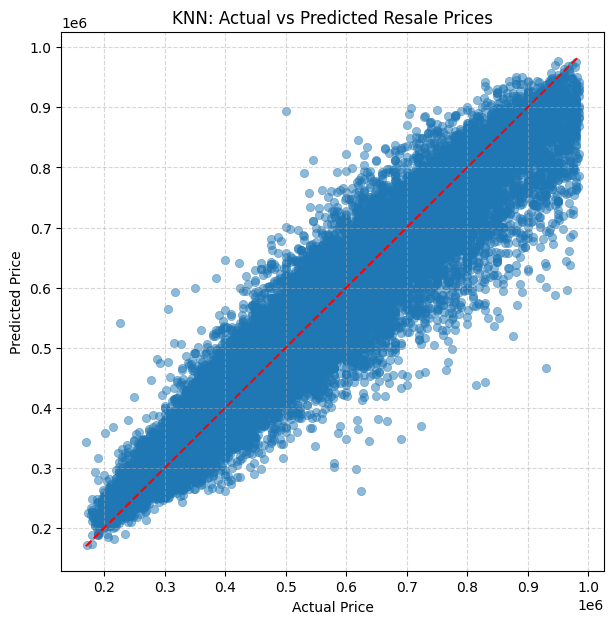

In [23]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_val, y=y_pred_knn, alpha=0.5, edgecolor=None)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('KNN: Actual vs Predicted Resale Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()